In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from IPython.display import Image

In [1]:
! unzip /content/drive/MyDrive/Combined_Dataset.zip
dataset_dir = "/content/content/AIRecognition"

Streaming output truncated to the last 5000 lines.
  inflating: content/AIRecognition/fake/fake-v2/13943.png  
  inflating: content/AIRecognition/fake/fake-v2/2587.jpg  
  inflating: content/AIRecognition/fake/fake-v2/11963.jpg  
  inflating: content/AIRecognition/fake/fake-v2/20878.png  
  inflating: content/AIRecognition/fake/fake-v2/13839.png  
  inflating: content/AIRecognition/fake/fake-v2/19956.png  
  inflating: content/AIRecognition/fake/fake-v2/22093.png  
  inflating: content/AIRecognition/fake/fake-v2/2704.jpg  
  inflating: content/AIRecognition/fake/fake-v2/16898.png  
  inflating: content/AIRecognition/fake/fake-v2/20703.png  
  inflating: content/AIRecognition/fake/fake-v2/23931.png  
  inflating: content/AIRecognition/fake/fake-v2/17039.png  
  inflating: content/AIRecognition/fake/fake-v2/2647.jpg  
  inflating: content/AIRecognition/fake/fake-v2/24691.png  
  inflating: content/AIRecognition/fake/fake-v2/19245.png  
  inflating: content/AIRecognition/fake/fake-v2/1372

In [3]:
img_height = 224
img_width = 224
batch_size = 100

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  shuffle=True,
  subset="training",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    RandomRotation(0.2),  # Randomly rotate images by 20%
    RandomZoom(0.2),  # Randomly zoom into images
    RandomContrast(0.2),  # Randomly adjust contrast
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

class_names = train_ds.class_names

Found 27548 files belonging to 2 classes.
Using 22039 files for training.
Found 27548 files belonging to 2 classes.
Using 5509 files for validation.


In [4]:
# Building the Transfer Learning model using EfficientNetV2B0
EfficientNet_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top = False,
    weights = 'imagenet',
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
EfficientNet_base_model.trainable = True

# Create a new model on top of the EfficientNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = EfficientNet_base_model(inputs, training = False)
x = BatchNormalization()(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(rate = 0.4, seed = 512)(x)
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
EfficientNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
EfficientNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
EfficientNet_model.summary()

24274472/24274472 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                              

In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

EfficientNet_model_history = EfficientNet_model.fit(
    augmented_train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
EfficientNet_model.save('EfficientNet_withoutL2')

Epoch 1/100
221/221 [==============================] - 186s 604ms/step - loss: 0.1826 - accuracy: 0.9305 - precision: 0.9010 - recall: 0.9017 - val_loss: 0.1382 - val_accuracy: 0.9543 - val_precision: 0.9748 - val_recall: 0.8938
Epoch 2/100
221/221 [==============================] - 122s 536ms/step - loss: 0.1019 - accuracy: 0.9613 - precision: 0.9516 - recall: 0.9377 - val_loss: 0.1265 - val_accuracy: 0.9555 - val_precision: 0.9754 - val_recall: 0.8969
Epoch 3/100
221/221 [==============================] - 121s 528ms/step - loss: 0.0698 - accuracy: 0.9742 - precision: 0.9692 - recall: 0.9571 - val_loss: 0.1700 - val_accuracy: 0.9514 - val_precision: 0.9878 - val_recall: 0.8733
Epoch 4/100
221/221 [==============================] - 121s 529ms/step - loss: 0.0486 - accuracy: 0.9824 - precision: 0.9785 - recall: 0.9715 - val_loss: 0.1192 - val_accuracy: 0.9635 - val_precision: 0.9396 - val_recall: 0.9584
Epoch 5/100
221/221 [==============================] - 121s 529ms/step - loss: 0.028

In [6]:
val_loss, val_accuracy, val_precision, val_recall = EfficientNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

56/56 [==============================] - 24s 370ms/step - loss: 0.1192 - accuracy: 0.9635 - precision: 0.9396 - recall: 0.9584
Val Loss: 0.1192
Val Accuracy: 0.9635
Val Precision: 0.9396
Val Recall: 0.9584


In [7]:
! scp -r /content/EfficientNet_withoutL2 /content/drive/MyDrive/

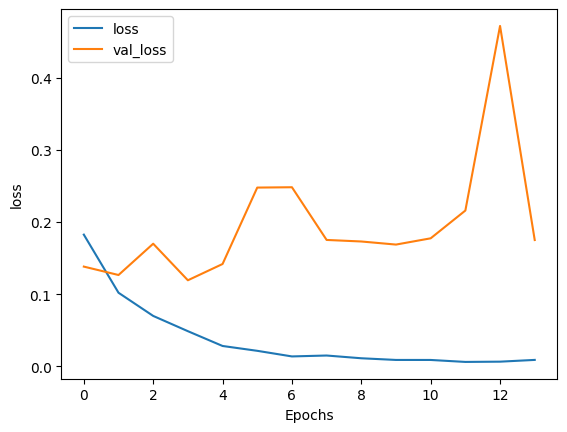

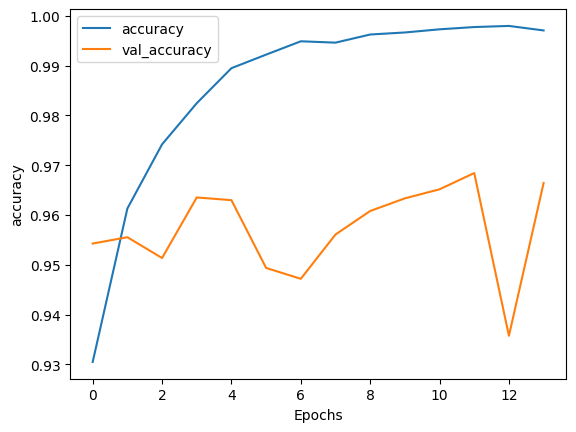

In [8]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_metrics(EfficientNet_model_history, 'loss')
plot_metrics(EfficientNet_model_history, 'accuracy')